# Notebook for predicting strategies

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.2 MB/s eta 0:00:00


In [3]:
import pdb
import numpy as np
from scipy.spatial import ConvexHull
import numpy.matlib as matlib
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
from shapely.geometry import box, MultiPolygon, Polygon, LineString, Point
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as pl
from matplotlib import collections  as mc
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *
from tqdm import trange
import time

In [4]:
import os
import cvxpy as cp
import pickle
import numpy as np
import pdb
import time
import random
import sys
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Sigmoid
from datetime import datetime
import itertools

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Loading the data

We want to learn Y (the binary sequences)

In [5]:
# Loading the data
data = np.load("drive/MyDrive/MIP/Receding + learning/19.12/data_simple.npz")

## Train test split

In [6]:
X_train , Y_train, x0y0_train = data['X'][:240000, :, :], data['Y'][:240000, :, :], data['param_x0y0'][:240000, :]





## Constructing the features

Our only parameters are the starting positions. We define here a function that constructs features that will be used later when saving strategies. Can easily integrate more than one starting parameter.

In [7]:
def construct_features(x0y0):
  feature_vec = np.array([])
  feature_vec = np.hstack((x0y0))
  return feature_vec

## Detecting active constraints

Let us first get our matrices A and B that will be used to detect violated constraints in the data.

In [8]:
def pol2ver(polygon):
    """
    pol2ver function gets the vertices from a polygon (shapely object).
    """
    xo, yo = polygon.exterior.xy
    vertices = np.array(list(set(list(zip(xo,yo)))))
    return vertices


def ver2con(V):
    """ 
    ver2con function maps vertices of a convex polygon
    to linear constraints stored in matrices A and b. And it works.
    """
    k = ConvexHull(V).vertices 
    u = np.roll(k,-1)

    k = np.vstack((k,u)).T
    c = np.mean(V[k[:,0]], axis = 0)

    V = V - matlib.repmat(c, V.shape[0],1)

    A = np.zeros((k.shape[0], V.shape[1]))
    A[:] = np.nan
    rc = 0

    for ix in range(k.shape[0]):
        F = V[k[ix]]
        if matrix_rank(F, 1e-5) == F.shape[0]:
            rc = rc+1
            A[rc-1,:] = np.linalg.solve(F,np.ones((F.shape[0])))

    A = A[0:rc,:]
    b = np.ones((A.shape[0], 1))
    b = b.T + A @ c

    return(A, b)



def map_def():

    map_x_min = -1.6
    map_x_max = 1.6
    map_y_min = -3.5
    map_y_max = 3.5
    map = [map_x_min, map_x_max, map_y_min, map_y_max]

    robot_radius = 0.2

    obstacles = []
    obstacles.append(LineString([(-1.498, 2.998), (0.001, 3.000)]))
    obstacles.append(LineString([(1.051, 3.001), (1.494, 3.000)]))
    obstacles.append(LineString([(1.494, 3.000), (1.493, 0.430)]))
    obstacles.append(LineString([(1.494, -0.374), (1.497, -2.998)]))
    obstacles.append(LineString([(0.002, -2.999), (1.497, -2.998)]))
    obstacles.append(LineString([(-1.498, -2.999), (-1.050, -2.999)]))
    obstacles.append(LineString([(-1.496,-0.500), (-1.498, -2.999)]))
    obstacles.append(LineString([(-1.496, 0.750), (-1.495, 0.299)]))
    obstacles.append(LineString([(-1.498, 2.998), (-1.498, 1.553)]))
    obstacles.append(LineString([(-0.481, 2.382), (0.879, 1.356)]))
    obstacles.append(LineString([(-1.498, 1.553), (-0.700, 1.551)]))
    obstacles.append(LineString([(1.018, 0.429), (1.493, 0.430)]))
    obstacles.append(LineString([(0.141, 1.040), (-0.269, 0.524)]))
    obstacles.append(LineString([(-1.496, 0.526), (-0.269, 0.524)]))
    obstacles.append(LineString([(-0.269, 0.524), (-0.261, -0.008)]))
    obstacles.append(LineString([(-0.261,-0.008), (0.480, -0.008)]))
    obstacles.append(LineString([(0.011, -0.008), (0.011, -0.486)]))
    obstacles.append(LineString([(-1.496, -0.859), (-0.492, -0.860)]))
    obstacles.append(LineString([(0.922, -0.613), (0.924, -2.093)]))
    obstacles.append(LineString([(0.260, -1.084), (0.260, -2.093)]))
    obstacles.append(LineString([(-0.665, -2.094), (0.924, -2.093)]))
    obstacles.append(LineString([(-0.685, -2.103), (-0.931, -2.414)]))

    dilated_obstacles = []
    area_obstacles = MultiPolygon()

    A_list = [] # List of matrices A for A * x <= b for each obstacle
    b_list = []

    for line in obstacles:
        dilated = line.buffer(0.025 + robot_radius, cap_style = 3,join_style = 2)
        dilated = dilated.minimum_rotated_rectangle
        dilated_obstacles.append(dilated)
        area_obstacles = area_obstacles.union(dilated)
        vertices = pol2ver(dilated)
        A, b = ver2con(vertices)
        A_list.append(-A) #minus to get the constraint to be outside the polygon
        b_list.append(-b)

    area_obstacles = area_obstacles.simplify(tolerance=0.05)
    obstacles_boundary = []
    for geom in area_obstacles.geoms:    
        xo, yo = geom.exterior.xy
        obstacles_boundary.append(list(zip(xo,yo)))

    return(map, area_obstacles, obstacles_boundary, dilated_obstacles, robot_radius, A_list, b_list)

In [9]:
_, _, _, _, _, A_list, b_list = map_def()
matrices = list(zip(A_list, b_list))

# Here a the computed matrices
matrices =[(np.array([[ 1.02616565e+00,  1.36913362e-03],
       [-5.92987390e-03,  4.44444049e+00],
       [-1.02616565e+00, -1.36913362e-03],
       [ 5.92987390e-03, -4.44444049e+00]]), np.array([[ -1.76397896,  12.33331554,  -0.23602104, -14.33331554]])), (np.array([[ 2.23963312, -0.00505561],
       [ 0.01003258,  4.44443312],
       [-2.23963312,  0.00505561],
       [-0.01003258, -4.44443312]]), np.array([[  1.8347638 ,  12.34828804,  -3.8347638 , -14.34828804]])), (np.array([[ 2.57685433e-04,  6.62251563e-01],
       [-4.44444411e+00,  1.72935568e-03],
       [-2.57685433e-04, -6.62251563e-01],
       [ 4.44444411e+00, -1.72935568e-03]]), np.array([[ 0.13614628, -7.63481143, -2.13614628,  5.63481143]])), (np.array([[ 4.44444154e+00,  5.08129749e-03],
       [-7.43845997e-04,  6.50617299e-01],
       [-4.44444154e+00, -5.08129749e-03],
       [ 7.43845997e-04, -6.50617299e-01]]), np.array([[ 5.63809526, -2.09805319, -7.63809526,  0.09805319]])), (np.array([[ 1.02827723e+00,  6.87810855e-04],
       [-2.97287187e-03,  4.44444345e+00],
       [-1.02827723e+00, -6.87810855e-04],
       [ 2.97287187e-03, -4.44444345e+00]]), np.array([[ -0.23136862, -14.32889185,  -1.76863138,  12.32889185]])), (np.array([[ 0.00000000e+00, -4.44444444e+00],
       [ 2.22717149e+00,  2.46716228e-16],
       [ 0.00000000e+00,  4.44444444e+00],
       [-2.22717149e+00, -0.00000000e+00]]), np.array([[ 12.32888889,  -3.83741648, -14.32888889,   1.83741648]])), (np.array([[ 4.44444302e+00, -3.55697721e-03],
       [ 5.42773587e-04,  6.78195597e-01],
       [-4.44444302e+00,  3.55697721e-03],
       [-5.42773587e-04, -6.78195597e-01]]), np.array([[-7.64710827, -2.18731573,  5.64710827,  0.18731573]])), (np.array([[ 4.44443352,  0.00985462],
       [-0.00492184,  2.21974764],
       [-4.44443352, -0.00985462],
       [ 0.00492184, -2.21974764]]), np.array([[-7.64148158,  0.17161824,  5.64148158, -2.17161824]])), (np.array([[ 0.        ,  1.05540897],
       [-4.44444444, -0.        ],
       [-0.        , -1.05540897],
       [ 4.44444444,  0.        ]]), np.array([[ 1.40158311,  5.65777778, -3.40158311, -7.65777778]])), (np.array([[ 2.67667404,  3.54802797],
       [-0.74136682,  0.55929585],
       [-2.67667404, -3.54802797],
       [ 0.74136682, -0.55929585]]), np.array([[ 6.16392241, -0.10220806, -8.16392241, -1.89779194]])), (np.array([[ 1.11389235e-02,  4.44443049e+00],
       [-1.60255585e+00,  4.01643070e-03],
       [-1.11389235e-02, -4.44443049e+00],
       [ 1.60255585e+00, -4.01643070e-03]]), np.array([[ 5.88551444,  0.76744238, -7.88551444, -2.76744238]])), (np.array([[ 0.0093567 , -4.4444346 ],
       [ 2.16215491,  0.00455191],
       [-0.0093567 ,  4.4444346 ],
       [-2.16215491, -0.00455191]]), np.array([[-2.89713732,  1.71654053,  0.89713732, -3.71654053]])), (np.array([[ 3.47971977, -2.76489362],
       [ 1.12185599,  1.41189681],
       [-3.47971977,  2.76489362],
       [-1.12185599, -1.41189681]]), np.array([[-3.38484887,  0.03230452,  1.38484887, -2.03230452]])), (np.array([[ 1.19260310e+00, -1.94393333e-03],
       [ 7.24439860e-03,  4.44443854e+00],
       [-1.19260310e+00,  1.94393333e-03],
       [-7.24439860e-03, -4.44443854e+00]]), np.array([[-2.0534928 ,  1.32693705,  0.0534928 , -3.32693705]])), (np.array([[ 4.44394202,  0.0668262 ],
       [-0.03062113,  2.03630492],
       [-4.44394202, -0.0668262 ],
       [ 0.03062113, -2.03630492]]), np.array([[-2.16040348, -0.46651873,  0.16040348, -1.53348127]])), (np.array([[ 5.59306310e-16,  4.44444444e+00],
       [-1.67926113e+00, -0.00000000e+00],
       [-3.72870873e-16, -4.44444444e+00],
       [ 1.67926113e+00, -2.46716228e-16]]), np.array([[-1.03555556, -1.18387909, -0.96444444, -0.81612091]])), (np.array([[ 0.        ,  2.15517241],
       [-4.44444444, -0.        ],
       [-0.        , -2.15517241],
       [ 4.44444444,  0.        ]]), np.array([[-1.53232759, -1.04888889, -0.46767241, -0.95111111]])), (np.array([[ 4.42673530e-03,  4.44444224e+00],
       [-1.37551467e+00,  1.37003453e-03],
       [-4.42673530e-03, -4.44444224e+00],
       [ 1.37551467e+00, -1.37003453e-03]]), np.array([[-4.82439828,  0.36608403,  2.82439828, -2.36608403]])), (np.array([[ 4.44444039e+00,  6.00600052e-03],
       [-1.40036184e-03,  1.03626776e+00],
       [-4.44444039e+00, -6.00600052e-03],
       [ 1.40036184e-03, -1.03626776e+00]]), np.array([[ 3.09409236, -2.40336281, -5.09409236,  0.40336281]])), (np.array([[-4.93432455e-16,  1.37080192e+00],
       [-4.44444444e+00, -0.00000000e+00],
       [-4.93432455e-16, -1.37080192e+00],
       [ 4.44444444e+00,  0.00000000e+00]]), np.array([[-3.17751885, -2.15555556,  1.17751885,  0.15555556]])), (np.array([[ 9.80872631e-01,  6.17289258e-04],
       [-2.79700665e-03,  4.44444356e+00],
       [-9.80872631e-01, -6.17289258e-04],
       [ 2.79700665e-03, -4.44444356e+00]]), np.array([[ -0.87426929, -10.30480481,  -1.12573071,   8.30480481]])), (np.array([[ 3.48578419, -2.75724409],
       [ 1.46569887,  1.85297703],
       [-3.48578419,  2.75724409],
       [-1.46569887, -1.85297703]]), np.array([[ 2.41072215, -6.36923332, -4.41072215,  4.36923332]]))]

Now we define a function to detect violated constraints

In [10]:
def get_active_constraints(X, matrices , ineq_tol = 1e-5 ):
  """
  X: np array positions 2 x T

  matrices is a list of tuples A, B created by zipping A_list and B_list
  A_list : List of matrices A, len nobs, 4 rows, 2 columns] 4 sides 2 dim
  b_list : List of matrices b, len nobs, 4 rows 1 column

  return violations : indices of active big M constraints
  
  """
  violations = [] # list of obstacle big M violations
  n_obs = len(matrices)
  T = X.shape[1]

  for i_obs, (A,b) in enumerate(matrices):                                          # obstacle considered
    curr_violations = []
    for i_t in range(T):                                                            # check all step times
      for i_side in range(A.shape[0]):                                              # One constraint for each side to check
        if  A[i_side,0]*X[0,i_t] + A[i_side,1]*X[1,i_t] - b[0][i_side] > ineq_tol:  # Original formula is Ax <= b violated if Ax - b > 0, thus, we check here which constraints are violated
          curr_violations.append(i_side + 4*i_t)                                    # curr_violations has the size of violated constraints and refers to side violated in which timestep.
    violations.append(curr_violations)                                              # appended for all obstacles

  return violations

## Defining strategies (labels)

In [11]:
def construct_strategies(n_features, X, Y, x0y0, matrices, test_data=None):
    """ Reads in training data and constructs strategy dictonary

    return features : num_probs x 4, x0 y0 xe ye
    return labels : num_probs x 4
    strategy_dict : key is active constraints, value is tuple seq
    """
    strategy_dict = {}                                                          # Initialize dictionnary
  
    # X contains the positions
    # Y contains the binary strategies

    n_y = int(Y[0].size / len(matrices))                                        # Y[0].size is equal to the number of binaries in the problem (88 binaries times 4 timesteps)
                                                                                # len(matrices) = 22 obstacles
                                                                                # n_y is equal to 4 times 4 timesteps here

    num_probs = Y.shape[0]                                                      # number of problems in the training set 
    print(num_probs)
    features = np.zeros((num_probs*len(matrices), n_features))                  # features : number of problems times number of matrices (recall we separate strategies for each obstacles, thus we need to duplicate features)
                                                                                # n_features is the number of features (if starting position x y, n_features will be equal to 2)

    labels = np.zeros((num_probs*len(matrices), n_y + 1), dtype = int)          # labels : number of problems times number of matrices(obstacles), 
                                                                                # 4 sides times 4 timesteps, we add one to store the NUMBER of the startegy
                                                                               
    n_strategies = 0                                                            # initialize the number of strategies to 0

    # x0y0 features (starting positions)

    for ii in range(num_probs):                                                 # loop through problems solved
      obs_strats = get_active_constraints(X[ii], matrices)                      # get active constraints for trajectory of problem ii                                                    
      param_x0y0 = x0y0[ii]                                                     # get the features of problem ii
      
      for ii_obs in range(len(matrices)):                                       # loop through matrices (meaning through obstacles)
        y_true = np.reshape(Y[ii, 4*ii_obs:4*(ii_obs+1),:], n_y)                # we reshape Y of problem ii with the 4 binaries of an obstacle and all time_step to a 1D vector of length n_y (4_sides times 4_timesteps)
        obs_strat = tuple(obs_strats[ii_obs])                                   # Here we fetch the side and timesteps at which a constraints are violated (same violations implies same solution !!!!)

        if obs_strat not in strategy_dict.keys():                                           # First, we check if our violated constraint is in the set of stategies ------- If it is :
            strategy_dict[obs_strat] = np.hstack((n_strategies, np.copy(y_true)))           # We add stategy with the number it is and the sequence of binaries
            n_strategies += 1                                                               # Adds 1 to number of strategies

        labels[ii*len(matrices)+ii_obs] = strategy_dict[obs_strat]                          # We add the strategies to the labels of problem ii, obstacle_ii
        features[ii*len(matrices)+ii_obs] = construct_features(param_x0y0)                   
  
    return features, labels, num_probs, strategy_dict

In [12]:
# Now that everything is setp up, we construct strategies for the training data.
features, labels, num_probs, strategy_dict = construct_strategies(2, X_train, Y_train, x0y0_train, matrices) 
# Let's check how many strategies we found !
n_strategies = len(strategy_dict)                                                      
print('The number of strategies found in the training data is : {} .'.format(n_strategies))   

240000
The number of strategies found in the training data is : 90 .


## Setting up the neural network and features for training.

In [13]:
features

array([[-0.52603651, -1.55813594],
       [-0.52603651, -1.55813594],
       [-0.52603651, -1.55813594],
       ...,
       [ 1.01545394, -2.46452054],
       [ 1.01545394, -2.46452054],
       [ 1.01545394, -2.46452054]])

In [14]:
labels[:,0]

array([ 0,  1,  2, ...,  8, 60, 13])

In [15]:
# We use one hot encoding to encode which obstacle we are in ! Recommended way to do so :
# https://towardsdatascience.com/an-overview-of-categorical-input-handling-for-neural-networks-c172ba552dee
nums_obstacle = range(0,22)
nums_obstacle = np.matlib.repmat(nums_obstacle, 1, 240000)
print(nums_obstacle)

[[ 0  1  2 ... 19 20 21]]


In [16]:
import torch.nn.functional as F
nums_obstacle = torch.from_numpy(nums_obstacle[0])
one_hot_obs = F.one_hot(nums_obstacle, num_classes = 22)

In [17]:
labels_torch = torch.from_numpy(labels[:,0])
x0_torch = torch.from_numpy(features[:,0]).view(-1,1) # feature 1
y0_torch = torch.from_numpy(features[:,1]).view(-1,1) # feature 2
x = torch.hstack([x0_torch, y0_torch, one_hot_obs])
y = labels_torch

In [18]:
y.view(-1)

tensor([ 0,  1,  2,  ...,  8, 60, 13])

In [19]:
x

tensor([[-0.5260, -1.5581,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5260, -1.5581,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5260, -1.5581,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0155, -2.4645,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0155, -2.4645,  0.0000,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0155, -2.4645,  0.0000,  ...,  0.0000,  0.0000,  1.0000]],
       dtype=torch.float64)

In [20]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=24, output_dim= 90, n_hidden = 256 ):  
    super(LinearClassifier, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, n_hidden)
    self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
    self.fc3 = torch.nn.Linear(n_hidden, output_dim)


  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

### Training with minibatch stochastic gradient descent

In [21]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

  
# Create the dataset
data = x
labels = y
dataset = MyDataset(data, labels)

In [22]:
model = LinearClassifier()
criterion = torch.nn.CrossEntropyLoss()

In [23]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


# Initialize empty list to store losses
all_loss = []

for epoch in range(3):
  for i, data in enumerate(dataloader):
    inputs_train, labels_train = data
    optimizer.zero_grad()
    output = model(inputs_train.float())
    loss = criterion(output, labels_train.view(-1).long())
    loss.backward()
    optimizer.step()

    # Append loss to list
    all_loss.append(loss.item())
    
    if not i % 100:
      torch.save(model.state_dict(), 'drive/MyDrive/MIP/Receding + learning/19.12/pred_strategies.ckpt')

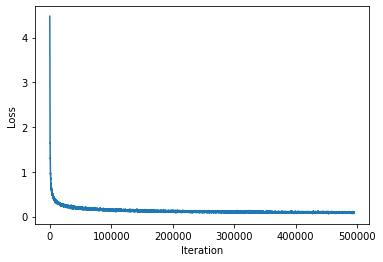

In [31]:
def moving_average(loss_values, window_size):
    moving_average = []
    for i in range(len(loss_values)):
        if i < window_size:
            # Use the simple average for the first few elements
            moving_average.append(np.mean(loss_values[:i+1]))
        else:
            # Otherwise, use the moving average
            moving_average.append(np.mean(loss_values[i-window_size+1:i+1]))
    return moving_average

# Compute the moving average with a window size of 100
ma = moving_average(all_loss, window_size=100)

# Plot the loss values
plt.plot(ma)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('plot.png', dpi=300)
plt.show()


In [30]:
# Accuracy on train set:
_, predicted = torch.max(F.softmax(model(x.float())),1)
y_test = y.view(-1).long()
correct = (predicted == y_test).sum().item()
accuracy = 100 * correct / len(y_test)
print('Model accuracy on the training set is :{}'.format(accuracy))

<ipython-input-30-4320246b7c39>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(model(x.float())),1)


Model accuracy on the training set is :96.46568181818182


## Saving the mapping between labels and strategies (binary sequences)

In [33]:
# Now fetch binaries in the training set (in the strategy dictionnary):
list_strat = list(strategy_dict.values())
strats = {}
for lst in list_strat:
  strats[lst[0]]= lst[1:]

In [34]:
with open('drive/MyDrive/MIP/Receding + learning/19.12/strategy_mapping1912.pkl', 'wb') as f:
    pickle.dump(strats, f)